# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Доступен набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

Подключим необходимые библиотеки и выставим полезные умолчания.

In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns
pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows

Загрузим и проанализируем данные о возрасте людей на фотографиях.

In [6]:
labels = pd.read_csv('/datasets/faces/labels.csv', index_col=[0])
labels

,real_age
file_name,
000000.jpg,4
000001.jpg,18
000002.jpg,80
000003.jpg,50
000004.jpg,17
...,...
007608.jpg,14
007609.jpg,37
007610.jpg,28


In [8]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


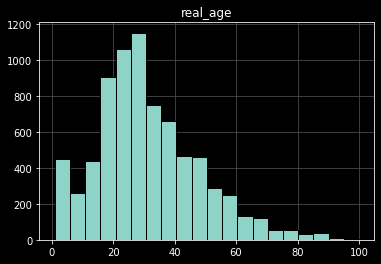

In [11]:
labels.hist(bins=20, edgecolor='k');

В датасете более 7,5 тысяч фото людей в возрасте от 1 года до 100 лет. Средний возраст – 31 год, медианный – 29 лет. Половину датасета составляют фото людей в возрасте от 20 лет до 41 года – в этом диапазоне следует ожидать наибольшую точность будущей модели.

Взглянем на несколько первых фото из датасета.

In [12]:
labels = labels.squeeze()

In [13]:
folder = '/datasets/faces/final_files/'

In [14]:
def showimg(filename, ax=None, axis=True):
    image = np.array(Image.open(folder + filename))
    if not ax:
        ax = plt.gca();
    ax.imshow(image);
    ax.grid(False);
    if not axis:
        ax.axis('off');

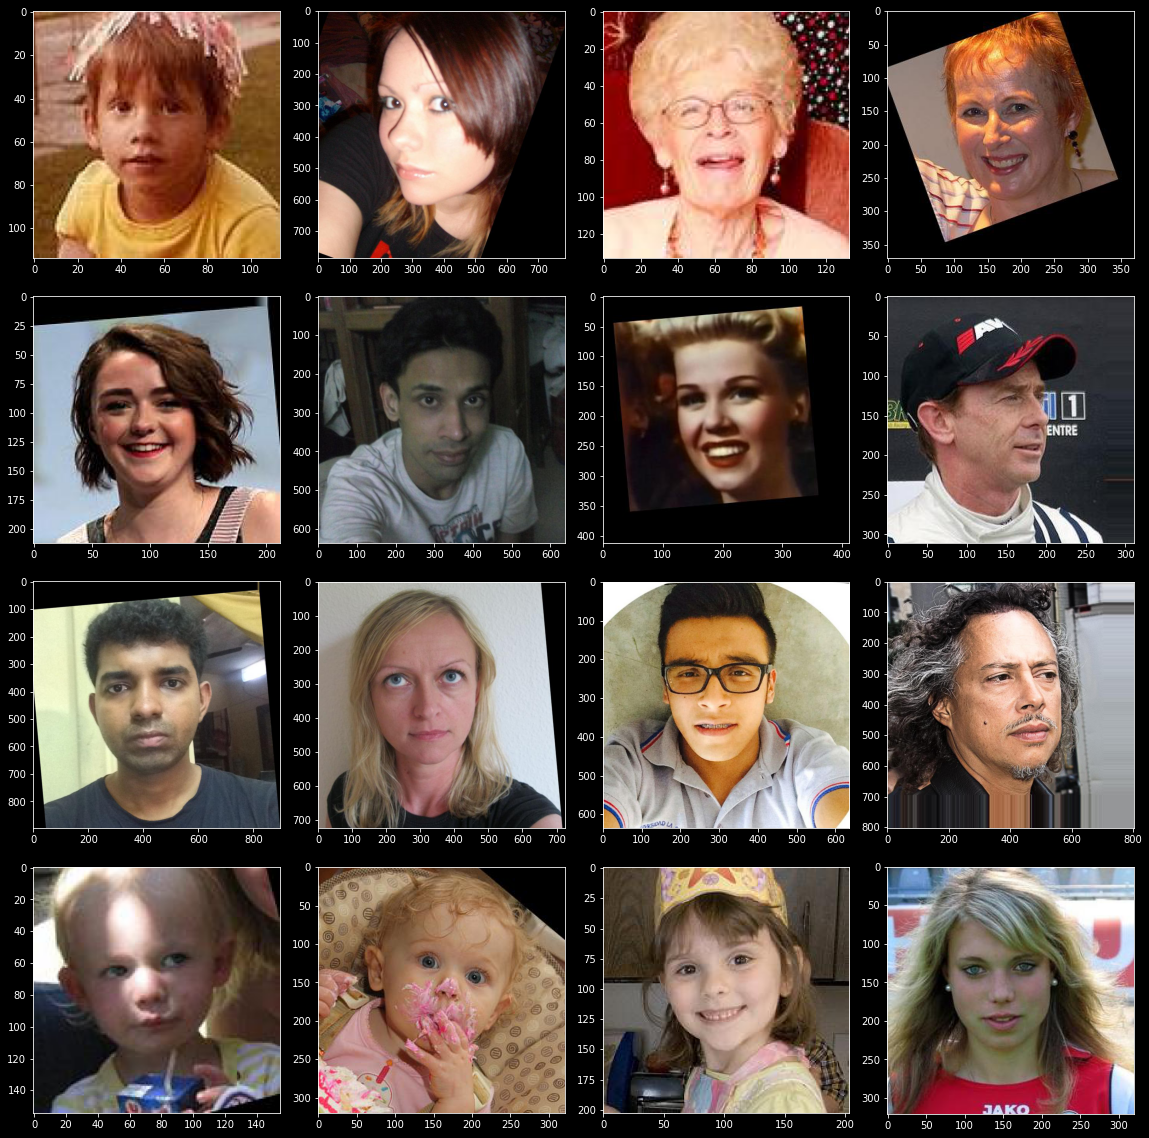

In [15]:
fig = plt.figure(figsize=(16, 16), tight_layout=True);
for i in range(16):
    showimg(labels.index[i], fig.add_subplot(4, 4, i+1))

Посмотрим также на фото самого молодого и самого старого человека.

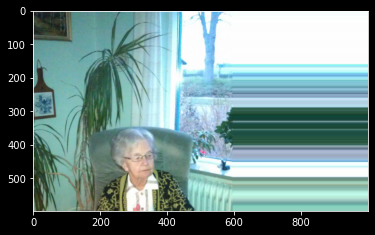

In [153]:
showimg(labels.idxmax())

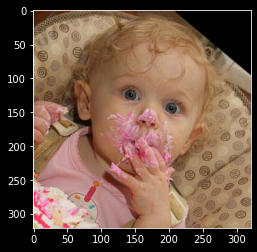

In [154]:
showimg(labels.idxmin())

Все фото разного размера. Одни фото повернуты, у других заметно увеличение размера (копированием крайних пикселов).

Исследуем размеры фото. Для этого сначала считаем в датафрейм размеры всех фото.

In [16]:
%%time
imgsizes = pd.DataFrame(
    [Image.open(folder + filename).size for filename in labels.index],
    columns=['width', 'height'], 
    index=labels.index,
)
imgsizes

CPU times: user 3.28 s, sys: 1.98 s, total: 5.26 s
Wall time: 5min 51s


,width,height
file_name,,
000000.jpg,114,114
000001.jpg,784,784
000002.jpg,133,133
000003.jpg,370,370
000004.jpg,212,212
...,...,...
007608.jpg,159,159
007609.jpg,260,260
007610.jpg,116,116


In [17]:
imgsizes.describe()

,width,height
count,7591.000000,7591.000000
mean,464.733764,464.093927
std,330.834794,331.289883
min,47.000000,47.000000
25%,220.000000,220.000000
50%,385.000000,384.000000
75%,632.000000,632.000000
max,4466.000000,4466.000000


Построим скеттерплот ширина-высота.

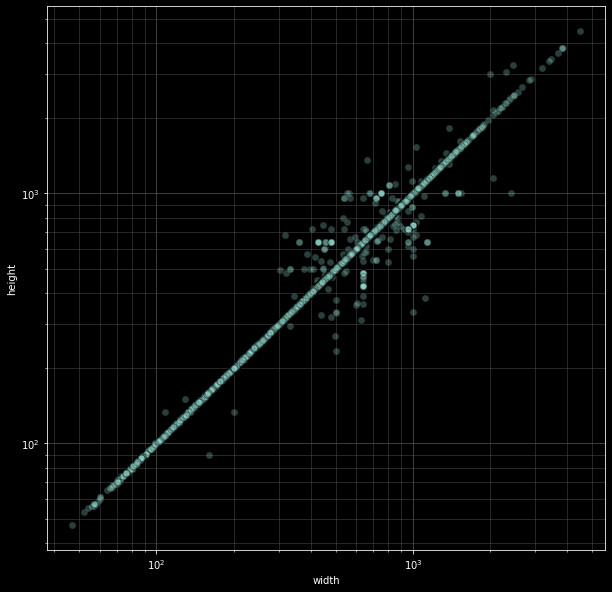

In [18]:
imgsizes.plot.scatter('width', 'height',
    figsize=(10, 10), s=50, linewidths=1, edgecolors='k', alpha=.3, loglog=True,
);
plt.grid(True, 'minor', lw=.5);

Построим гистограмму ширин и высот.

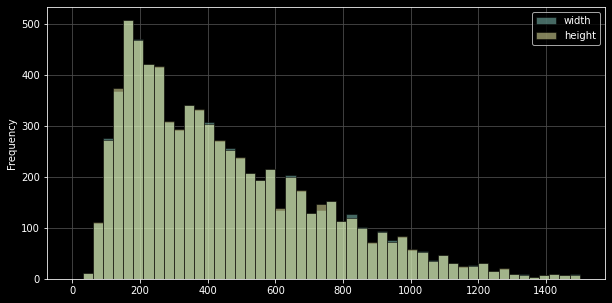

In [19]:
imgsizes.plot.hist(bins=50, range=(0, 1500), edgecolor='k', alpha=.5, 
                   ax=plt.gca(), figsize=(10, 5));
plt.legend();

Построим гистограмму отличия ширины от высоты.

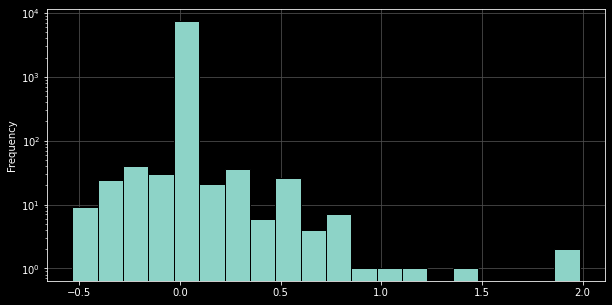

In [20]:
(imgsizes['width']/imgsizes['height'] - 1).plot.hist(
    bins=20, edgecolor='k', logy=True, figsize=(10, 5));

Наконец, построим кривую распределения ширин.

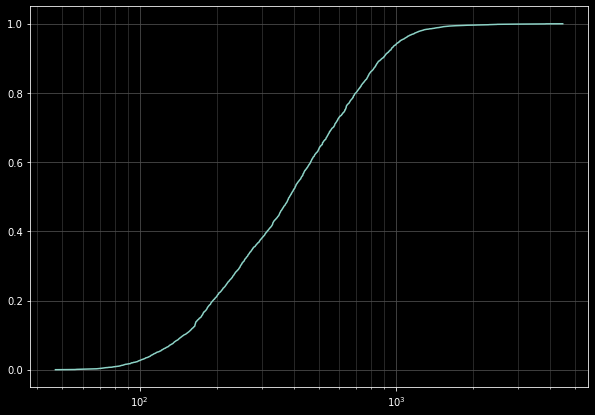

In [23]:
imgsizes['width'].value_counts(normalize=True).sort_index().cumsum().plot(logx=True, figsize=(10, 7));
plt.grid(True, 'minor', 'x', lw=.5);

Размеры фото варьируются от 47х47 до 4466х4466. Средний размер – около 465х465, медианный – около 385х385. Видим, что подавляющее большинство фото – квадратные. Значит можно смело их рисайзить перед подачей в модель: сильные искажения растяжения/сжатия возникнут лишь у незначительной части фото.

## Выводы

- В датасете более 7,5 тысяч фото – этого должно хватить для обучения ResNet50
- Фотографии корректно повернуты, где это необходимо
- Наибольшую точность будущей модели следует ожидать в диапазоне возрастов примерно 20–40 лет, потому что большую часть датасета составляют фото людей именно в этом возрасте
- Квадратных фото в датасете подавляющее большинство, поэтому рисайз фото перед подачей в модель не навредит качеству

# Обучение

Обучим модель ResNet50, инициализировав веса ImageNet'ом и заменив в «голове» полносвязный слой единственным нейроном с активацией ReLU (ниже скрипт обучения модели и его вывод).

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

RS = 22221111
from numpy.random import seed
seed(RS)
import tensorflow as tf
tf.random.set_seed(RS)

IMG_SIZE = 224

In [ ]:
def load_train(path):
    print()
    print(f'loading train from {path}...')
    labels = pd.read_csv(path + 'labels.csv')
    gen_train = ImageDataGenerator(
        validation_split=0.25, rescale=1/255., 
    )
    return gen_train.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col=labels.columns[0],
        y_col=labels.columns[1],
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=RS,
    )

In [ ]:
def load_test(path):
    print()
    print(f'loading test from {path}...')
    labels = pd.read_csv(path + 'labels.csv')
    gen_valid = ImageDataGenerator(
        validation_split=0.25, rescale=1/255., 
    )
    return gen_valid.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col=labels.columns[0],
        y_col=labels.columns[1],
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=RS,
    )

In [ ]:
def create_model(input_shape):
    print()
    print(f'creating model with input_shape={input_shape}...')
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
    ) 
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001), 
        loss='mse', 
        metrics=['mae']
    )
    
    print()
    print(model.summary())

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    print()
    print('training model...')
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, 
        shuffle=True,
    )
    return model 

```
2022-08-24 20:42:43.323808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-08-24 20:42:43.325820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-08-24 20:42:44.265780: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-24 20:42:44.276983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-24 20:42:44.277090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-24 20:42:44.277143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-24 20:42:44.279364: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-24 20:42:44.279725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-24 20:42:44.281732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-24 20:42:44.282880: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-24 20:42:44.282954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-24 20:42:44.288472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.

loading train from /datasets/faces/...
Found 5694 validated image filenames.

loading test from /datasets/faces/...
Found 1897 validated image filenames.

creating model with input_shape=(224, 224, 3)...
2022-08-24 20:42:44.468920: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-24 20:42:44.475781: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-08-24 20:42:44.476533: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x44f6cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-24 20:42:44.476570: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-24 20:42:44.635344: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3b56fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-24 20:42:44.635384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-24 20:42:44.637429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-24 20:42:44.637503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-24 20:42:44.637520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-24 20:42:44.637560: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-24 20:42:44.637578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-24 20:42:44.637595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-24 20:42:44.637612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-24 20:42:44.637624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-24 20:42:44.641221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-24 20:42:44.641292: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-24 20:42:45.055819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-24 20:42:45.055876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-24 20:42:45.055887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-24 20:42:45.059699: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-24 20:42:45.059760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

training model...
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-08-24 20:42:55.991289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-24 20:42:56.428927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 62s - loss: 210.2551 - mae: 10.5916 - val_loss: 665.6757 - val_mae: 20.7238
Epoch 2/10
356/356 - 59s - loss: 70.8796 - mae: 6.4264 - val_loss: 129.1569 - val_mae: 8.8012
Epoch 3/10
356/356 - 56s - loss: 35.5900 - mae: 4.6253 - val_loss: 99.6227 - val_mae: 7.5975
Epoch 4/10
356/356 - 47s - loss: 22.0625 - mae: 3.6275 - val_loss: 74.4603 - val_mae: 6.5482
Epoch 5/10
356/356 - 56s - loss: 15.9081 - mae: 3.0996 - val_loss: 70.8862 - val_mae: 6.3515
Epoch 6/10
356/356 - 56s - loss: 13.1761 - mae: 2.7869 - val_loss: 72.6393 - val_mae: 6.4694
Epoch 7/10
356/356 - 40s - loss: 11.7457 - mae: 2.6050 - val_loss: 75.9916 - val_mae: 6.5961
Epoch 8/10
356/356 - 56s - loss: 10.9373 - mae: 2.5273 - val_loss: 71.2432 - val_mae: 6.2748
Epoch 9/10
356/356 - 55s - loss: 10.9643 - mae: 2.4940 - val_loss: 72.4127 - val_mae: 6.4658
Epoch 10/10
356/356 - 46s - loss: 9.9345 - mae: 2.4004 - val_loss: 66.6339 - val_mae: 6.2029
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 66.6339 - mae: 6.2029
Test MAE: 6.2029
```

## Выводы

- В качестве стартовой модели для обучения использована предобученная на ImageNet модель ResNet50, в которой верхний слой заменен единственным нейроном с активацией ReLU
- В результате полного обучения модели на имеющемся датасете удалось достичь средней абсолютной ошибки определения возраста на тестовой выборке в 6,2 года
- Полученная точность позволяет использовать модель для определения возрастной группы покупателя, но не позволяет – для контроля добросовестности кассиров при продаже алкоголя